# **Part A**
Count / Frequency based Naive Bayes Classifier

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Students must implement the following steps:
# 1. Complete the fit method in NaiveBayesClassifier (4 TODOs for log prior and log likelihood calculation).
# 2. Complete the predict method in NaiveBayesClassifier (2 TODOs for log probability accumulation and final argmax).
# 3. Complete the data loading calls in Section 2.
# 4. Initialize CountVectorizer with proper parameters in Section 3a.
# 5. Complete the feature transformation (fit_transform and transform) in Section 3a.
# 6. Initialize and fit the custom nb_model in Section 3b.
# 7. Use the fitted nb_model to generate predictions in Section 4.
# =======================================================


# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # Calculate the log prior and store it in self.class_priors[c]
            # P(C) = (Number of samples in class c) / (Total number of samples)
            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Apply Laplace smoothing
            # P(w_i | C) = (count(w_i, C) + alpha) / (total_words_in_C + alpha * vocab_size)
            numerator = feature_sum + self.alpha
            denominator = total_mass + self.alpha * self.vocabulary_size

            # Calculate the log likelihood
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}
            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # Log-Sum Trick: log_prob += sum(count(w_i) * log(P(w_i|C)))
                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                scores[c] = log_prob

            # Find the class with maximum score
            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)

        return np.array(y_pred)


In [7]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))


    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [8]:
if X_train is not None and len(X_train) > 0:
    # Initialize CountVectorizer
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        ngram_range=(1, 2),  # Using unigrams and bigrams
        min_df=5  # Ignore terms appearing in fewer than 5 documents
    )

    print("\n✓ Fitting Count Vectorizer and transforming training data...")
    X_train_counts = count_vectorizer.fit_transform(X_train)
    print(f"  Vocabulary size: {X_train_counts.shape[1]}")
    print(f"  Training matrix shape: {X_train_counts.shape}")

    print("\n✓ Transforming test data...")
    X_test_counts = count_vectorizer.transform(X_test)
    print(f"  Test matrix shape: {X_test_counts.shape}")

else:
    print("❌ Skipping: Training data is empty or not loaded.")



✓ Fitting Count Vectorizer and transforming training data...
  Vocabulary size: 86557
  Training matrix shape: (180040, 86557)

✓ Transforming test data...
  Test matrix shape: (30135, 86557)


In [9]:
if X_train is not None and len(X_train) > 0:
    # Initialize and train the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier(alpha=1.0)

    print("\n✓ Training the Custom Naive Bayes Classifier...")
    nb_model.fit(X_train_counts, y_train)
    print("  Training complete!")
    print(f"  Number of classes: {len(nb_model.classes)}")
    print(f"  Classes: {nb_model.classes}")

else:
    print("❌ Skipping: Training data is empty or not loaded.")


✓ Training the Custom Naive Bayes Classifier...
  Training complete!
  Number of classes: 5
  Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


In [10]:
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')

    print(f"\n✓ Accuracy: {accuracy:.4f}")
    print(f"✓ Macro-averaged F1 score: {test_f1:.4f}")
    print("\n" + "-" * 60)
    print("Classification Report:")
    print("-" * 60)
    print(classification_report(y_test, y_test_pred, target_names=target_names))
else:
    print("❌ Prediction failed or incomplete.")


✓ Accuracy: 0.7483
✓ Macro-averaged F1 score: 0.6809

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

  BACKGROUND       0.54      0.57      0.55      3621
 CONCLUSIONS       0.61      0.70      0.66      4571
     METHODS       0.83      0.85      0.84      9897
   OBJECTIVE       0.53      0.51      0.52      2333
     RESULTS       0.88      0.78      0.83      9713

    accuracy                           0.75     30135
   macro avg       0.68      0.69      0.68     30135
weighted avg       0.76      0.75      0.75     30135



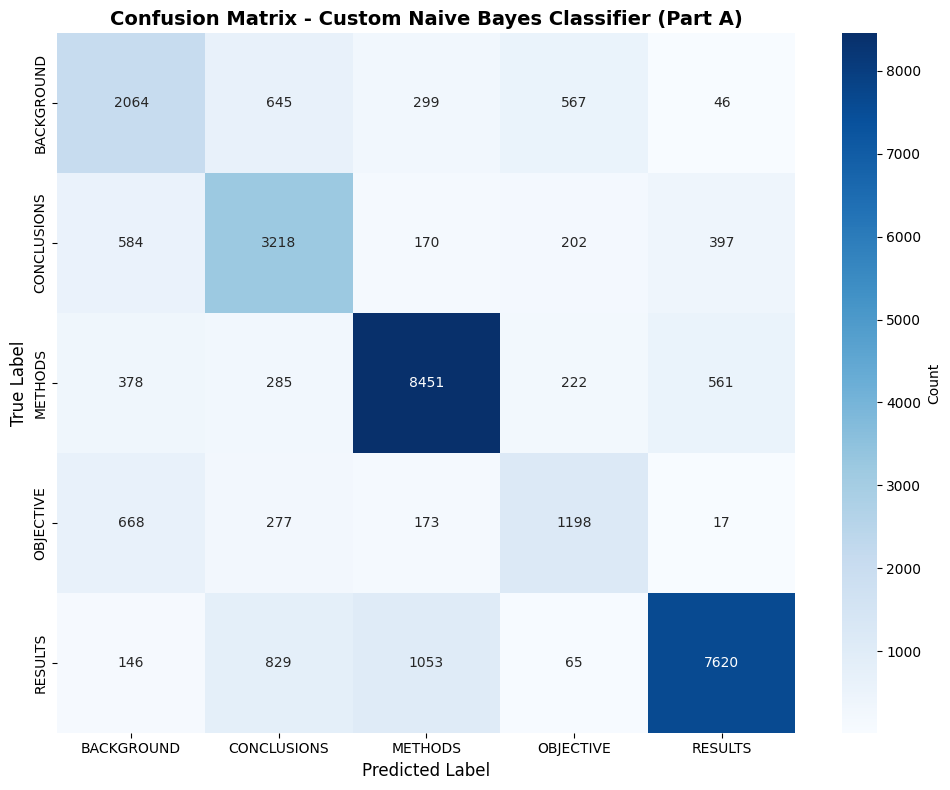

In [11]:
if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred, labels=target_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Custom Naive Bayes Classifier (Part A)',
              fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# **Part B**
TF-IDF score based Classifier


PART B: INITIAL SKLEARN MODEL

✓ Training initial Naive Bayes pipeline...
  Training complete!

✓ Accuracy: 0.6996
✓ Macro-averaged F1 score: 0.5555

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.37      0.46      3621
 CONCLUSIONS       0.61      0.55      0.57      4571
     METHODS       0.68      0.88      0.77      9897
   OBJECTIVE       0.72      0.09      0.16      2333
     RESULTS       0.77      0.85      0.81      9713

    accuracy                           0.70     30135
   macro avg       0.68      0.55      0.56     30135
weighted avg       0.69      0.70      0.67     30135


PART B: HYPERPARAMETER TUNING

✓ Starting Grid Search on Development Set...
  Total combinations to try: 24
  CV folds: 3
------------------------------------------------------------
Fitting 3 folds for each of 24 

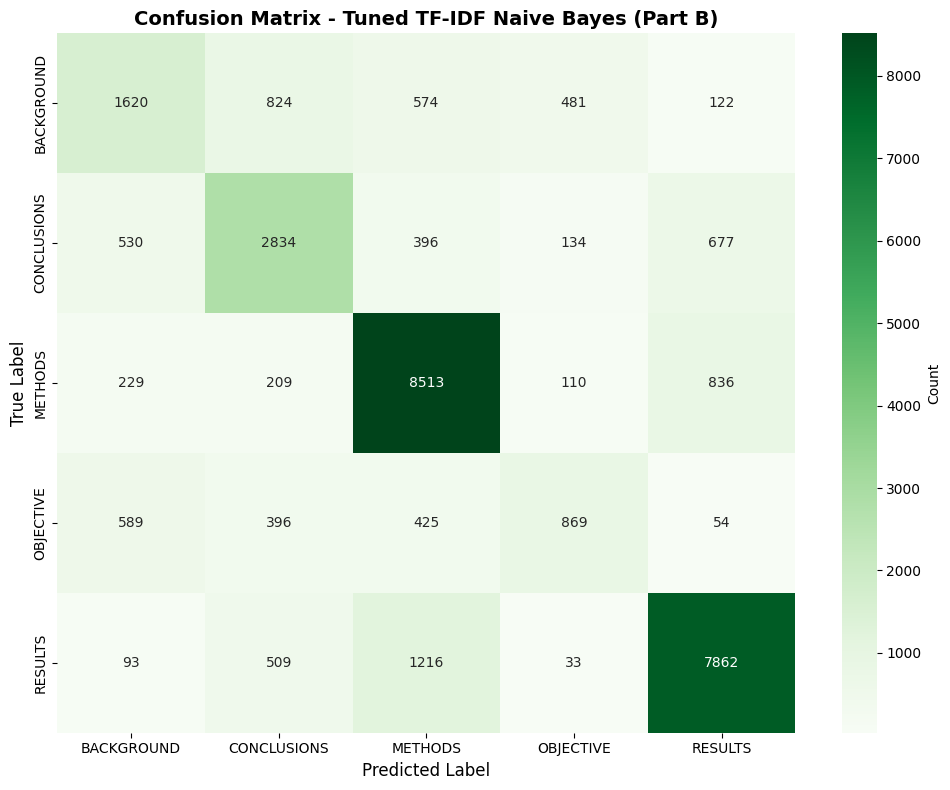

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Implement the following steps:
# 1. Define the initial `pipeline` combining TfidfVectorizer and MultinomialNB with default parameters.
# 2. Train the initial pipeline on the training data (X_train, y_train).
# 3. Predict and evaluate the performance of the initial model on the test data (X_test, y_test).
# 4. Define the `param_grid` for hyperparameter tuning.
# 5. Initialize `GridSearchCV` using the pipeline, parameter grid, and appropriate cross-validation settings.
# 6. Fit the Grid Search object using the development data (X_dev, y_dev).
# 7. Print the `best_params_` and `best_score_` found by the grid search.
# =======================================================
print("\n" + "=" * 60)
print("PART B: INITIAL SKLEARN MODEL")
print("=" * 60)

# Define Pipeline with TfidfVectorizer and MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english'
    )),
    ('nb', MultinomialNB())
])

# Train the initial pipeline
print("\n✓ Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("  Training complete!")


y_test_pred_initial = pipeline.predict(X_test)

if y_test_pred_initial is not None:
    accuracy_initial = accuracy_score(y_test, y_test_pred_initial)
    f1_initial = f1_score(y_test, y_test_pred_initial, average='macro')

    print(f"\n✓ Accuracy: {accuracy_initial:.4f}")
    print(f"✓ Macro-averaged F1 score: {f1_initial:.4f}")
    print("\n" + "-" * 60)
    print("Classification Report:")
    print("-" * 60)
    print(classification_report(y_test, y_test_pred_initial, target_names=target_names))
else:
    print("❌ Initial model evaluation skipped.")

print("\n" + "=" * 60)
print("PART B: HYPERPARAMETER TUNING")
print("=" * 60)

# Define parameter grid
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],  # Unigrams, unigrams+bigrams, bigrams
    'tfidf__min_df': [2, 5],  # Minimum document frequency
    'nb__alpha': [0.1, 0.5, 1.0, 2.0]  # Laplace smoothing parameter
}

# Initialize GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

print("\n✓ Starting Grid Search on Development Set...")
print(f"  Total combinations to try: {len(param_grid['tfidf__ngram_range']) * len(param_grid['tfidf__min_df']) * len(param_grid['nb__alpha'])}")
print(f"  CV folds: 3")
print("-" * 60)

# Fit grid search on development data
grid.fit(X_dev, y_dev)
print("\n✓ Grid search complete!")

if grid is not None and hasattr(grid, 'best_params_'):
    print("\n" + "=" * 60)
    print("PART B: GRID SEARCH RESULTS")
    print("=" * 60)

    print(f"\n✓ Best Parameters: {grid.best_params_}")
    print(f"✓ Best Cross-Validation F1 Score: {grid.best_score_:.4f}")

    # Evaluate best model on test set
    print("\n" + "=" * 60)
    print("PART B: TUNED MODEL TEST SET EVALUATION")
    print("=" * 60)

    y_test_pred_tuned = grid.predict(X_test)
    accuracy_tuned = accuracy_score(y_test, y_test_pred_tuned)
    f1_tuned = f1_score(y_test, y_test_pred_tuned, average='macro')

    print(f"\n✓ Accuracy: {accuracy_tuned:.4f}")
    print(f"✓ Macro-averaged F1 score: {f1_tuned:.4f}")
    print("\n" + "-" * 60)
    print("Classification Report:")
    print("-" * 60)
    print(classification_report(y_test, y_test_pred_tuned, target_names=target_names))

    # Confusion Matrix
    cm_tuned = confusion_matrix(y_test, y_test_pred_tuned, labels=target_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens',
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Tuned TF-IDF Naive Bayes (Part B)',
              fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("❌ Hyperparameter tuning skipped.")


# **Part C**
Bayes Optimal Classifier

Part C Draft


Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS341

✓ Full SRN: PES2UG23CS341
✓ Last 3 digits: 341
✓ Dynamic sample size: 10341
✓ Actual sampled training set size: 10341

✓ Defined 5 base hypotheses:
  • NaiveBayes
  • LogisticRegression
  • RandomForest
  • DecisionTree
  • KNN

✓ Sub-training set size: 8272
✓ Validation set size: 2069

------------------------------------------------------------

[1/5] Training NaiveBayes on sub-training set...
      Validation log-likelihood: -2021.5475

[2/5] Training LogisticRegression on sub-training set...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


      Validation log-likelihood: -1870.9740

[3/5] Training RandomForest on sub-training set...
      Validation log-likelihood: -2070.9869

[4/5] Training DecisionTree on sub-training set...
      Validation log-likelihood: -2611.5051

[5/5] Training KNN on sub-training set...
      Validation log-likelihood: -3000.3152

POSTERIOR WEIGHTS P(h_i | D)
  NaiveBayes          : 0.0000
  LogisticRegression  : 1.0000
  RandomForest        : 0.0000
  DecisionTree        : 0.0000
  KNN                 : 0.0000

[1/5] Training NaiveBayes...
      ✓ Complete

[2/5] Training LogisticRegression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


      ✓ Complete

[3/5] Training RandomForest...
      ✓ Complete

[4/5] Training DecisionTree...
      ✓ Complete

[5/5] Training KNN...
      ✓ Complete

✓ All base models trained successfully!

✓ Fitting VotingClassifier (BOC approximation)...
  ✓ Fitting complete!

✓ Making predictions on test set...

✓ Accuracy: 0.7090
✓ Macro-averaged F1 score: 0.6146

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

  BACKGROUND       0.55      0.37      0.44      3621
 CONCLUSIONS       0.61      0.56      0.58      4571
     METHODS       0.71      0.89      0.79      9897
   OBJECTIVE       0.66      0.35      0.45      2333
     RESULTS       0.80      0.81      0.80      9713

    accuracy                           0.71     30135
   macro avg       0.66      0.60      0.61     30135
weighted avg       0.70      0.71      0.69     30135



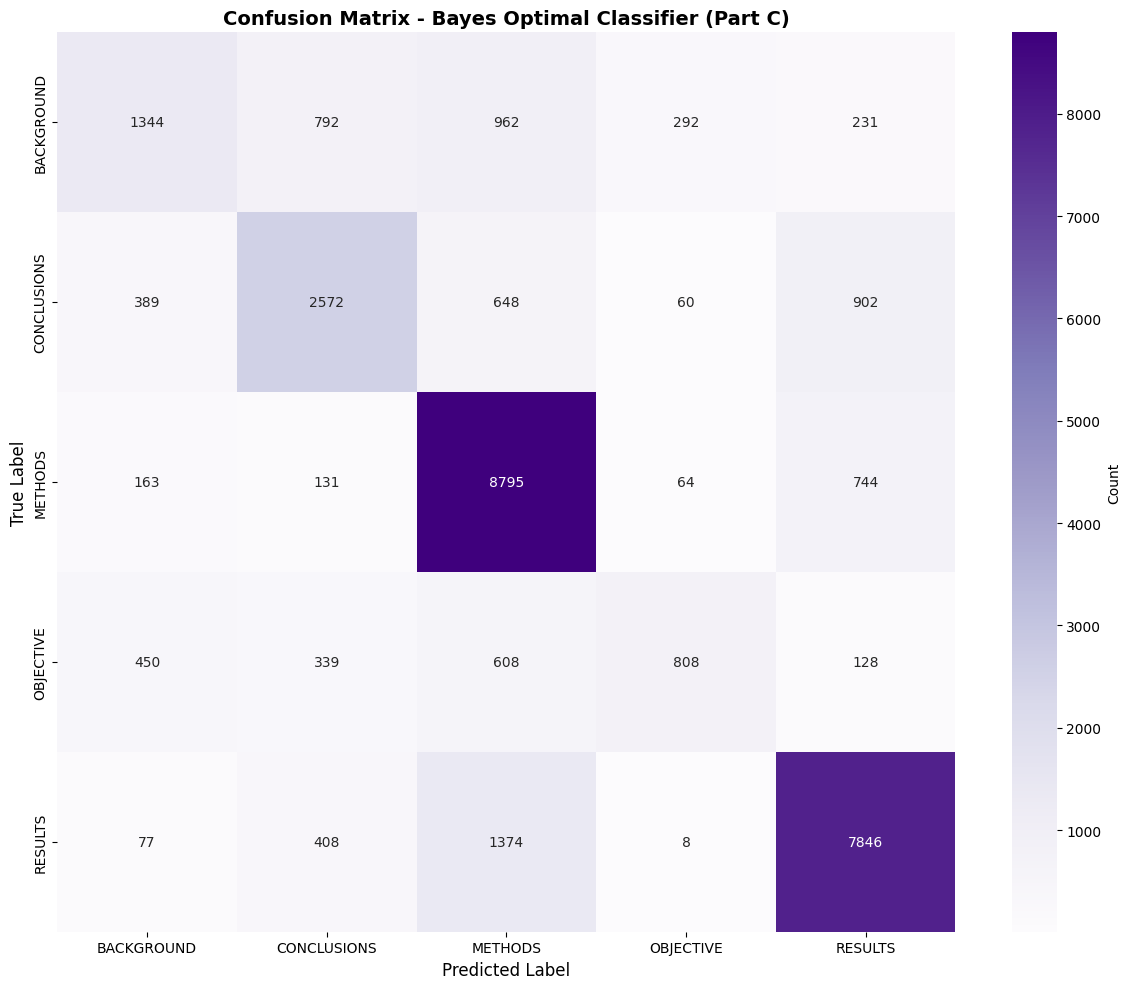


POSTERIOR WEIGHTS USED IN BOC
  NaiveBayes          : 0.0000
  LogisticRegression  : 1.0000
  RandomForest        : 0.0000
  DecisionTree        : 0.0000
  KNN                 : 0.0000

LAB COMPLETED SUCCESSFULLY!


                    Model  Accuracy  Macro F1
Part A: Custom NB (Count)  0.748333  0.680862
Part B: Initial TF-IDF NB  0.699585  0.555487
  Part B: Tuned TF-IDF NB  0.720027  0.631324
Part C: BOC (Soft Voting)  0.708976  0.614632


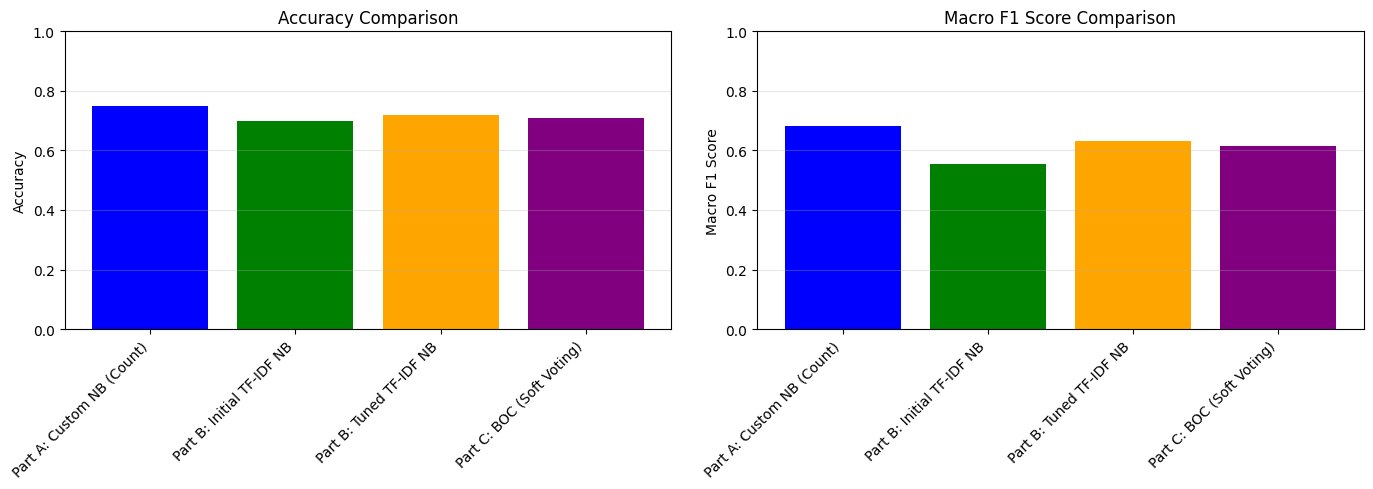


✓ Analysis complete! Ready for lab report.


In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split # Used for P(h|D) calculation

# =======================================================
# TODO: Implement the following steps:
# 1. Train all five hypotheses on the sampled training data.
# 2. Compute the Posterior Weights P(h_i | D) using a validation split.
# 3. Fit the VotingClassifier using the sampled training data.
# 4. Make final predictions and evaluate the BOC performance on the test data.
# =======================================================

BASE_SAMPLE_SIZE = 10000

# Prompt for SRN
FULL_SRN = input("\nPlease enter your full SRN (e.g., PES1UG22CS345): ")

try:
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    print("⚠ WARNING: SRN input failed. Using default (0).")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"\n✓ Full SRN: {FULL_SRN}")
print(f"✓ Last 3 digits: {srn_value}")
print(f"✓ Dynamic sample size: {SAMPLE_SIZE}")

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"✓ Actual sampled training set size: {effective_sample_size}")

# Base TF-IDF parameters
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 5
}

# H1: Multinomial Naive Bayes
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

# H2: Logistic Regression
h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])

# H3: Random Forest Classifier
h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1),
        cv=3, method='isotonic'
    ))
])

# H4: Decision Tree Classifier
h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42),
        cv=3, method='isotonic'
    ))
])

# H5: K-Nearest Neighbors
h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
        cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

print("\n✓ Defined 5 base hypotheses:")
for name in hypothesis_names:
    print(f"  • {name}")

# Split sampled data into sub-training and validation sets
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled,
    test_size=0.2,
    random_state=42,
    stratify=y_train_sampled
)

print(f"\n✓ Sub-training set size: {len(X_train_sub)}")
print(f"✓ Validation set size: {len(X_val_sub)}")

# Train all hypotheses and calculate validation log-likelihoods
log_likelihoods = []

print("\n" + "-" * 60)
for i, (name, model) in enumerate(zip(hypothesis_names, hypotheses)):
    print(f"\n[{i+1}/5] Training {name} on sub-training set...")
    model.fit(X_train_sub, y_train_sub)

    # Get probability predictions on validation set
    y_val_proba = model.predict_proba(X_val_sub)

    # Calculate log-likelihood
    y_val_indices = [list(model.classes_).index(label) for label in y_val_sub]
    log_likelihood = np.sum(np.log(y_val_proba[np.arange(len(y_val_sub)), y_val_indices] + 1e-10))
    log_likelihoods.append(log_likelihood)

    print(f"      Validation log-likelihood: {log_likelihood:.4f}")

# Convert log-likelihoods to posterior weights using softmax
log_likelihoods = np.array(log_likelihoods)
log_likelihoods_stable = log_likelihoods - np.max(log_likelihoods)
posterior_weights = np.exp(log_likelihoods_stable) / np.sum(np.exp(log_likelihoods_stable))

print("\n" + "=" * 60)
print("POSTERIOR WEIGHTS P(h_i | D)")
print("=" * 60)
for name, weight in zip(hypothesis_names, posterior_weights):
    print(f"  {name:20s}: {weight:.4f}")


for i, (name, model) in enumerate(zip(hypothesis_names, hypotheses)):
    print(f"\n[{i+1}/5] Training {name}...")
    model.fit(X_train_sampled, y_train_sampled)
    print(f"      ✓ Complete")

print("\n✓ All base models trained successfully!")


estimators = list(zip(hypothesis_names, hypotheses))

# BOC with soft voting and posterior weights
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\n✓ Fitting VotingClassifier (BOC approximation)...")
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("  ✓ Fitting complete!")


print("\n✓ Making predictions on test set...")
y_pred_boc = boc_soft_voter.predict(X_test)

if y_pred_boc is not None:
    # Calculate metrics
    accuracy_boc = accuracy_score(y_test, y_pred_boc)
    macro_f1_boc = f1_score(y_test, y_pred_boc, average='macro')

    print(f"\n✓ Accuracy: {accuracy_boc:.4f}")
    print(f"✓ Macro-averaged F1 score: {macro_f1_boc:.4f}")

    print("\n" + "-" * 60)
    print("Classification Report:")
    print("-" * 60)
    print(classification_report(y_test, y_pred_boc, target_names=target_names))

    # Confusion Matrix
    cm_boc = confusion_matrix(y_test, y_pred_boc, labels=target_names)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_boc, annot=True, fmt='d', cmap='Purples',
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Bayes Optimal Classifier (Part C)',
              fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Display posterior weights used
    print("\n" + "=" * 60)
    print("POSTERIOR WEIGHTS USED IN BOC")
    print("=" * 60)
    for name, weight in zip(hypothesis_names, posterior_weights):
        print(f"  {name:20s}: {weight:.4f}")

    print("\n" + "=" * 60)
    print("LAB COMPLETED SUCCESSFULLY!")
    print("=" * 60)
else:
    print("❌ Evaluation skipped: Predictions not generated.")


summary_data = {
    'Model': ['Part A: Custom NB (Count)', 'Part B: Initial TF-IDF NB',
              'Part B: Tuned TF-IDF NB', 'Part C: BOC (Soft Voting)'],
    'Accuracy': [
        accuracy_score(y_test, y_test_pred),
        accuracy_score(y_test, y_test_pred_initial),
        accuracy_score(y_test, y_test_pred_tuned) if 'y_test_pred_tuned' in locals() else 0,
        accuracy_score(y_test, y_pred_boc) if 'y_pred_boc' in locals() else 0
    ],
    'Macro F1': [
        f1_score(y_test, y_test_pred, average='macro'),
        f1_score(y_test, y_test_pred_initial, average='macro'),
        f1_score(y_test, y_test_pred_tuned, average='macro') if 'y_test_pred_tuned' in locals() else 0,
        f1_score(y_test, y_pred_boc, average='macro') if 'y_pred_boc' in locals() else 0
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n")
print(summary_df.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
ax1.bar(range(len(summary_df)), summary_df['Accuracy'], color=['blue', 'green', 'orange', 'purple'])
ax1.set_xticks(range(len(summary_df)))
ax1.set_xticklabels(summary_df['Model'], rotation=45, ha='right')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Comparison')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

# F1 Score comparison
ax2.bar(range(len(summary_df)), summary_df['Macro F1'], color=['blue', 'green', 'orange', 'purple'])
ax2.set_xticks(range(len(summary_df)))
ax2.set_xticklabels(summary_df['Model'], rotation=45, ha='right')
ax2.set_ylabel('Macro F1 Score')
ax2.set_title('Macro F1 Score Comparison')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Analysis complete! Ready for lab report.")